In [1]:
import multiprocessing
multiprocessing.cpu_count()

2

In [2]:
import numpy as np
import pylab as plt
import seaborn as sns
import sklearn
import pandas as pd
import itertools

# definition of HGPR 

In [3]:
class MostLikelyHGPR(object):
    def __init__(self, kernel, x_train, x_test, t_train, r_train, r_test, var_r_train, var_r_test):
        self.kernel = kernel
        self.x_train = x_train
        self.x_test = x_test
        self.t_train = t_train
        self.r_train = r_train
        self.r_test = r_test
        self.var_r_train = var_r_train
        self.var_r_test = var_r_test
        self.regression = GaussianProcessRegression(kernel=self.kernel, x_train=self.x_train, t_train=self.t_train \
                                                         , r_train=self.r_train)
        self.var_regression = GaussianProcessRegression(kernel=self.kernel, x_train=self.x_train \
                                                        , t_train=np.diag(self.r_train), r_train=self.var_r_train)

    def fit(self, learning_rate_gpr=0.1, max_iter_sampling=100, max_iter_gpr=100, sampling_num=100):
        self.regression.fit(learning_rate=learning_rate_gpr, max_iter=max_iter_gpr)
        mu_train, sigma_train = self.regression.predict_dist(x_test=self.x_train, r_test=self.r_train)
        try:
            for i in range(max_iter_sampling):
                r_before = np.array(self.r_train)
                for j in range(self.x_train.size):
                    if i == 0:
                        t_train_predict = np.random.normal(mu_train[j], np.sqrt(np.diag(sigma_train))[j], sampling_num)
                    else:
                        t_train_predict = np.random.normal(mu_train[j], np.sqrt(np.diag(self.r_train))[j], sampling_num)
                    r_predict = 0.5 * (1.0 / float(sampling_num)) \
                                * np.dot(self.t_train[j] - t_train_predict, self.t_train[j] - t_train_predict)
                    self.r_train[j, j] = r_predict
                if np.dot(np.diag(self.r_train) - np.diag(r_before), np.diag(self.r_train) - np.diag(r_before)) \
                        / np.diag(self.r_train).size < 1e-2:
                    self.var_regression.fit(learning_rate=learning_rate_gpr, max_iter=max_iter_gpr)
                    break
        except:
            raise

    def predict(self):
        var_mu_test, var_sigma_test = self.var_regression.predict_dist(self.x_test, self.var_r_test)
        for i in range(var_mu_test.size):
            self.r_test[i, i] = var_mu_test[i]
        self.regression.fit(learning_rate=100, max_iter=100)
        mu_test, sigma_test = self.regression.predict_dist(self.x_test, self.r_test)
        return mu_test, sigma_test

# データロードとデータ確認

In [4]:
cfile = 1000
fn_data = f'dwk_{cfile}keV-2.txt'
print(fn_data)
df = pd.read_csv(fn_data)
df.head()

dwk_1000keV-2.txt


,dwk,t_0,t_0-t_2,t_1-t_0,wk_0,r0,z0,phi0,r1,z1,phi1,tt_0,tt_1,del,tin,mod(tin_omg245),efmax,efmin
1,-1242.6,0.000644,2.731100e-08,2.328300e-09,970180.0,1.0527,-0.034652,0.86396,1.2417,-0.108690,1.3876,2.449100e-10,1.242300e-10,-9.940300e-11,2.573200e-09,3.972700e-11,0.0,0.0
2,42520.0,0.000644,2.744700e-08,2.492700e-09,968930.0,1.1051,-0.032431,0.86398,1.3205,-0.084776,1.3876,2.243000e-10,2.680200e-10,3.421200e-11,2.717000e-09,5.358700e-11,0.0,0.0
3,23058.0,0.000644,2.689400e-08,2.322300e-09,1011500.0,1.0571,-0.064781,0.86397,1.2491,-0.124920,1.3876,2.227400e-10,9.606100e-11,-8.309000e-11,2.545000e-09,1.155400e-11,0.0,0.0
4,28594.0,0.000644,2.754800e-08,2.454000e-09,1034500.0,1.0962,0.002034,0.86401,1.3040,-0.068976,1.3875,2.969200e-10,3.019400e-10,5.159700e-13,2.750900e-09,2.255200e-11,0.0,0.0
5,18995.0,0.000644,2.770400e-08,2.371500e-09,1049400.0,1.0697,0.026186,0.86399,1.2625,-0.066062,1.3876,1.939400e-10,1.164600e-10,-5.326600e-11,2.565400e-09,3.195200e-11,0.0,0.0


In [5]:
# statistic values
df.describe()

,dwk,t_0,t_0-t_2,t_1-t_0,wk_0,r0,z0,phi0,r1,z1,phi1,tt_0,tt_1,del,tin,mod(tin_omg245),efmax,efmin
count,2.526320e+05,252632.000000,2.526320e+05,2.526320e+05,2.526320e+05,252632.000000,252632.000000,252632.000000,252632.000000,252632.000000,252632.000000,2.526320e+05,2.526320e+05,2.526320e+05,2.526320e+05,2.526320e+05,252632.0,252632.0
mean,1.908674e+02,0.000652,3.019329e-08,2.658274e-09,9.981566e+05,1.072478,-0.039046,0.864124,1.266386,-0.100670,1.387515,2.039420e-10,2.041767e-10,-2.380212e-14,2.862216e-09,3.248779e-11,0.0,0.0
std,1.378620e+04,0.000230,4.494178e-09,4.076168e-10,2.875991e+04,0.054097,0.119918,0.008959,0.077869,0.068465,0.005610,1.174981e-10,1.178621e-10,6.404953e-11,4.241287e-10,1.874213e-11,0.0,0.0
min,-6.550300e+04,0.000027,2.400000e-12,3.300000e-12,9.500000e+05,0.911490,-0.342290,0.863940,0.979150,-0.290670,0.863880,2.023200e-15,4.062700e-15,-1.299200e-10,1.728400e-11,7.744800e-16,0.0,0.0
25%,-6.435350e+03,0.000482,2.746900e-08,2.402700e-09,9.729900e+05,1.041600,-0.119060,0.863950,1.219800,-0.145400,1.387500,1.023600e-10,1.022400e-10,-4.542200e-11,2.593300e-09,1.630500e-11,0.0,0.0
50%,8.428500e-08,0.000677,2.897900e-08,2.566800e-09,9.974400e+05,1.074500,-0.040346,0.863970,1.265300,-0.100590,1.387600,2.043000e-10,2.042400e-10,1.250950e-14,2.786100e-09,3.244800e-11,0.0,0.0
75%,6.528300e+03,0.000845,3.166700e-08,2.818200e-09,1.022700e+06,1.108800,0.038180,0.863990,1.319900,-0.056094,1.387600,3.051900e-10,3.062600e-10,4.529500e-11,3.038700e-09,4.868700e-11,0.0,0.0
max,7.280800e+04,0.001000,1.110300e-07,8.795700e-09,1.050000e+06,1.475700,0.287860,1.387500,1.498700,0.260570,1.387600,4.081600e-10,4.081600e-10,1.299200e-10,8.832900e-09,6.496000e-11,0.0,0.0


In [6]:
#df7 = df[(abs(df.iloc[:, 0]) >= 0.01) & (df.iloc[:,2]*2.45e9 >= 65) & (df.iloc[:,2]*2.45e9 <= 75)]
df7 = df[(abs(df.iloc[:, 0]) >= 0.01)]
df7 = df7.iloc[:,0:16]
df7.head()

,dwk,t_0,t_0-t_2,t_1-t_0,wk_0,r0,z0,phi0,r1,z1,phi1,tt_0,tt_1,del,tin,mod(tin_omg245)
1,-1242.6,0.000644,2.731100e-08,2.328300e-09,970180.0,1.0527,-0.034652,0.86396,1.2417,-0.108690,1.3876,2.449100e-10,1.242300e-10,-9.940300e-11,2.573200e-09,3.972700e-11
2,42520.0,0.000644,2.744700e-08,2.492700e-09,968930.0,1.1051,-0.032431,0.86398,1.3205,-0.084776,1.3876,2.243000e-10,2.680200e-10,3.421200e-11,2.717000e-09,5.358700e-11
3,23058.0,0.000644,2.689400e-08,2.322300e-09,1011500.0,1.0571,-0.064781,0.86397,1.2491,-0.124920,1.3876,2.227400e-10,9.606100e-11,-8.309000e-11,2.545000e-09,1.155400e-11
4,28594.0,0.000644,2.754800e-08,2.454000e-09,1034500.0,1.0962,0.002034,0.86401,1.3040,-0.068976,1.3875,2.969200e-10,3.019400e-10,5.159700e-13,2.750900e-09,2.255200e-11
5,18995.0,0.000644,2.770400e-08,2.371500e-09,1049400.0,1.0697,0.026186,0.86399,1.2625,-0.066062,1.3876,1.939400e-10,1.164600e-10,-5.326600e-11,2.565400e-09,3.195200e-11


In [7]:
len(df7)

222652

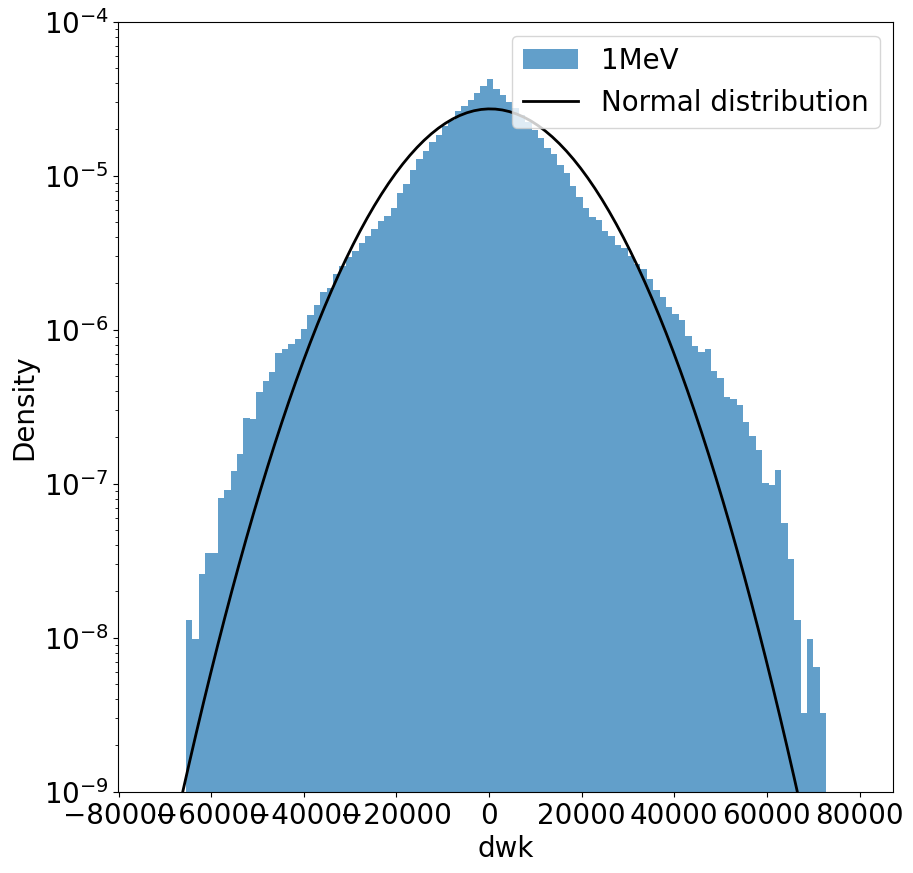

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# ヒストグラムのプロット
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams["font.size"] = 20
plt.hist(df7.iloc[:, 0].values, bins=100, alpha=0.7, density=True, label='1MeV')  # ヒストグラム

# 正規分布のパラメータの推定
mu, std = norm.fit(df7.iloc[:, 0].values)

# 正規分布の確率密度関数（PDF）を計算
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# 正規分布のプロット
plt.plot(x, p, 'k', linewidth=2, label='Normal distribution')

# プロットの設定
plt.xlabel('dwk')
plt.ylabel('Density')
plt.ylim(1e-9,1e-4)
plt.yscale('log')
plt.legend()
plt.savefig('./plt/hist_and_normal_distribution.1MeV.png')
plt.show()

In [9]:
#x = df.drop(df.iloc[:,0], axis=1)
X = df7.iloc[:,1:]
X.head()

,t_0,t_0-t_2,t_1-t_0,wk_0,r0,z0,phi0,r1,z1,phi1,tt_0,tt_1,del,tin,mod(tin_omg245)
1,0.000644,2.731100e-08,2.328300e-09,970180.0,1.0527,-0.034652,0.86396,1.2417,-0.108690,1.3876,2.449100e-10,1.242300e-10,-9.940300e-11,2.573200e-09,3.972700e-11
2,0.000644,2.744700e-08,2.492700e-09,968930.0,1.1051,-0.032431,0.86398,1.3205,-0.084776,1.3876,2.243000e-10,2.680200e-10,3.421200e-11,2.717000e-09,5.358700e-11
3,0.000644,2.689400e-08,2.322300e-09,1011500.0,1.0571,-0.064781,0.86397,1.2491,-0.124920,1.3876,2.227400e-10,9.606100e-11,-8.309000e-11,2.545000e-09,1.155400e-11
4,0.000644,2.754800e-08,2.454000e-09,1034500.0,1.0962,0.002034,0.86401,1.3040,-0.068976,1.3875,2.969200e-10,3.019400e-10,5.159700e-13,2.750900e-09,2.255200e-11
5,0.000644,2.770400e-08,2.371500e-09,1049400.0,1.0697,0.026186,0.86399,1.2625,-0.066062,1.3876,1.939400e-10,1.164600e-10,-5.326600e-11,2.565400e-09,3.195200e-11


In [10]:
#y = df.iloc[:,0]
y = df7.iloc[:,0]
y.head()

1    -1242.6
2    42520.0
3    23058.0
4    28594.0
5    18995.0
Name:          dwk, dtype: float64

# 学習データの生成

In [11]:
print(df7.columns)

Index(['         dwk', ' t_0', ' t_0-t_2', ' t_1-t_0', ' wk_0', ' r0', ' z0',
       ' phi0', ' r1', ' z1', ' phi1', ' tt_0', ' tt_1', ' del', ' tin',
       ' mod(tin_omg245)'],
      dtype='object')


In [12]:
# choose 6 columns for Gaussian process regression
df7_new = df7[[' t_0-t_2', ' t_1-t_0', ' r0', ' z0', ' r1', ' z1', ' tt_0', ' tt_1', ' tin']]
print(len(df7_new))

222652


In [13]:
from sklearn.model_selection import train_test_split

# 説明変数X, 目的変数y
X = df7_new.iloc[:, 0:]
X = (X - np.mean(X, 0)) / np.std(X, 0)
y = df7.iloc[:, 0]

train_size = 1000
val_size = 1000
test_size = 1000

# データの分割
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=42)
X_val, X_temp2, y_val, y_temp2 = train_test_split(X_temp, y_temp, train_size=val_size, random_state=44)

# テストデータ2の生成
X_test, _, y_test, _ = train_test_split(X_temp2, y_temp2, train_size=test_size, random_state=46)

# 必要な場合は、配列への変換
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
#X_test2 = np.array(X_test2)

# 必要な場合は、インデックスのリセット
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
#y_test2 = y_test2.reset_index(drop=True)

In [14]:
#statistics
from scipy.stats import kurtosis, skew

print(type(X_train))
print(len(X_train))
print(len(X_val))
print(len(X_test))

print(y_train.var(), y_train.kurt(), y_train.skew())
print(y_val.var(),y_val.kurt(),y_val.skew())
print(y_test.var(), y_test.kurt(), y_test.skew())

<class 'numpy.ndarray'>
1000
1000
1000
225322343.35713896 1.1469164109105878 0.04618122912845302
201096503.0383059 1.4547710052281313 0.15682990748595757
189023414.48745558 1.3315499657380703 0.05151121581120398


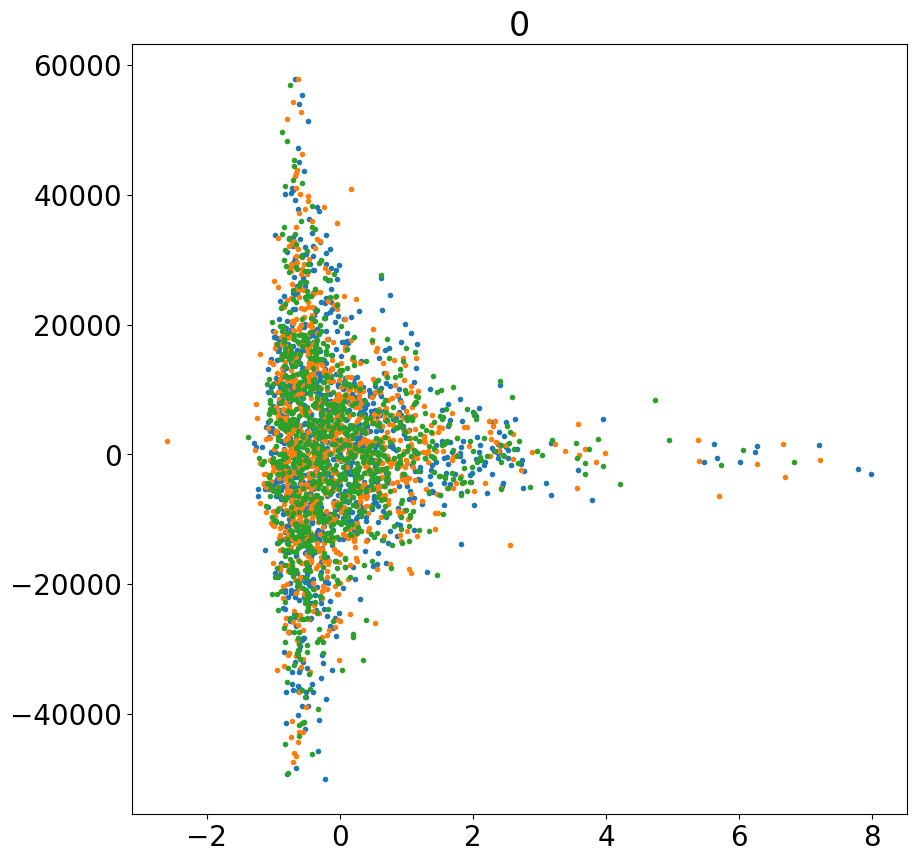

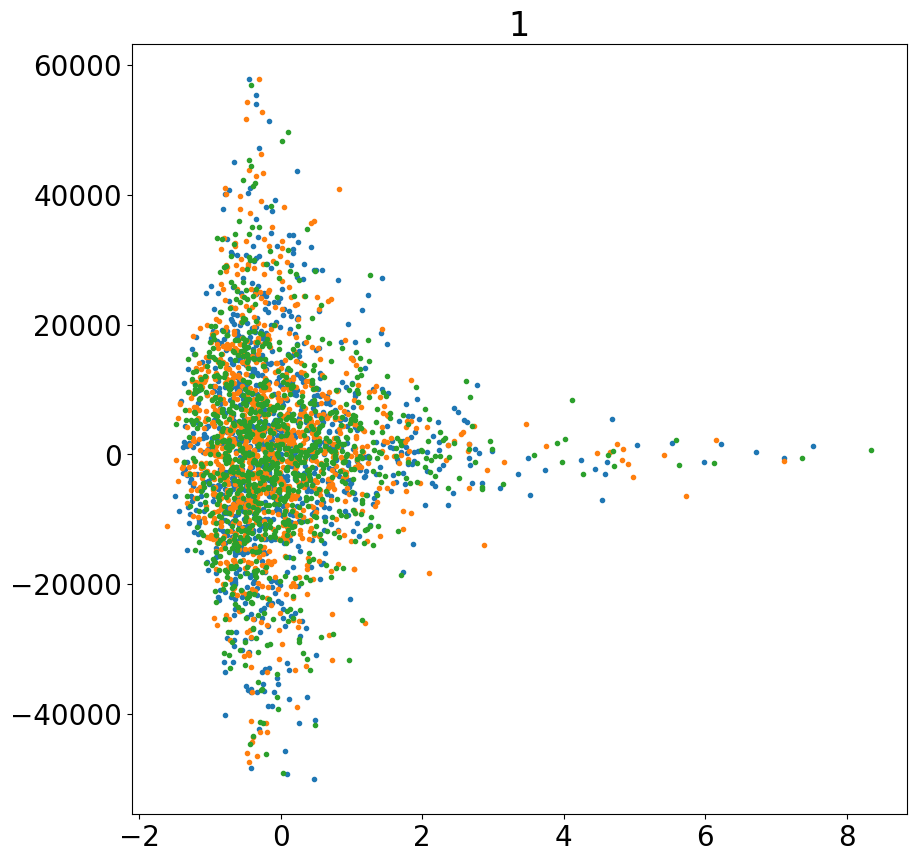

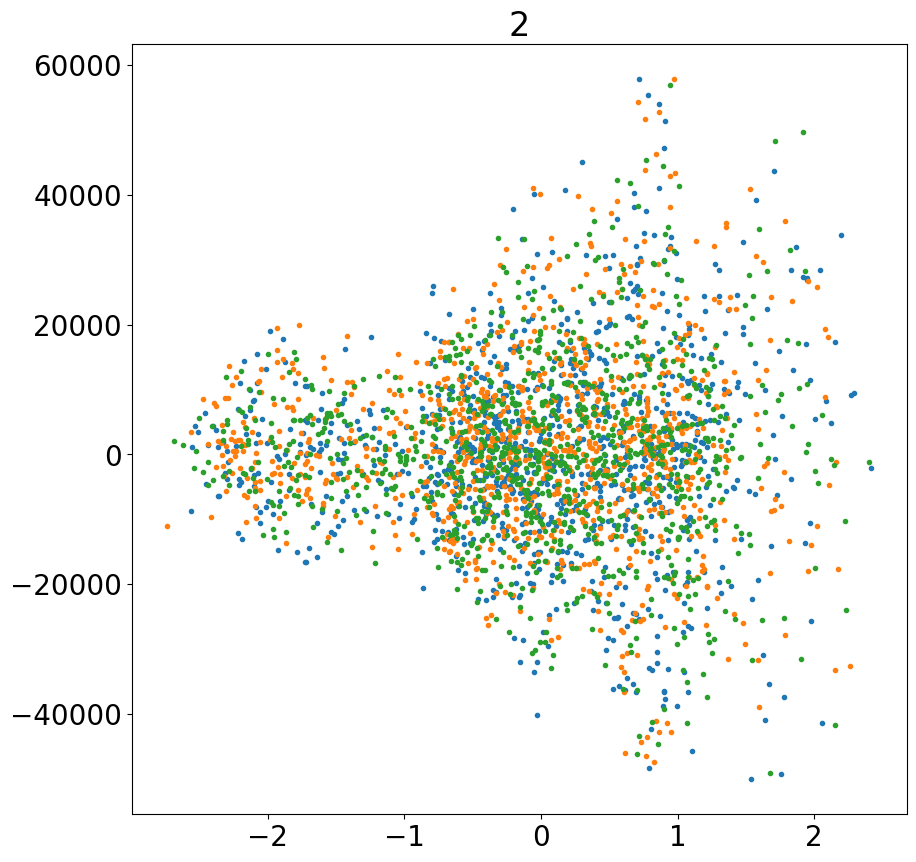

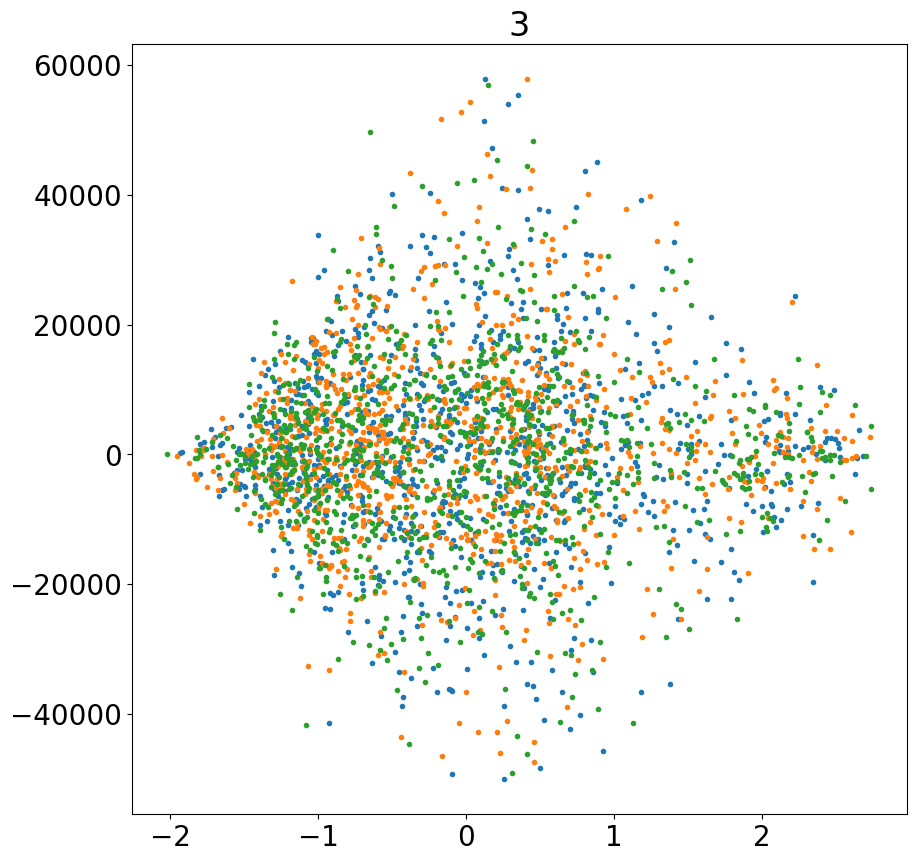

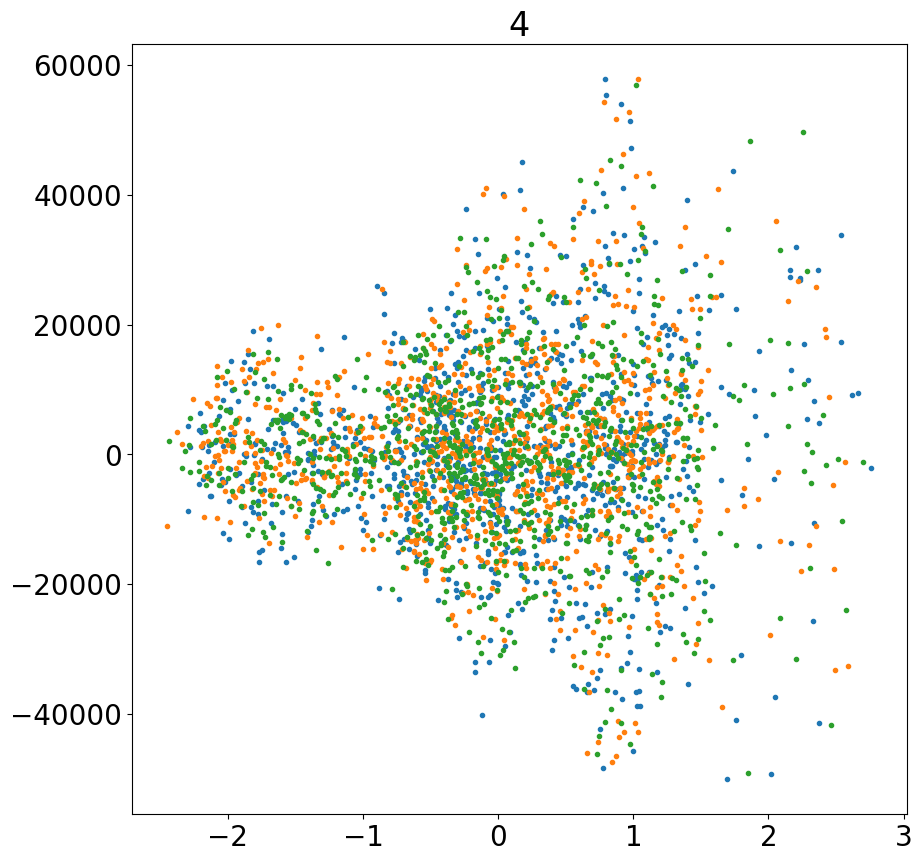

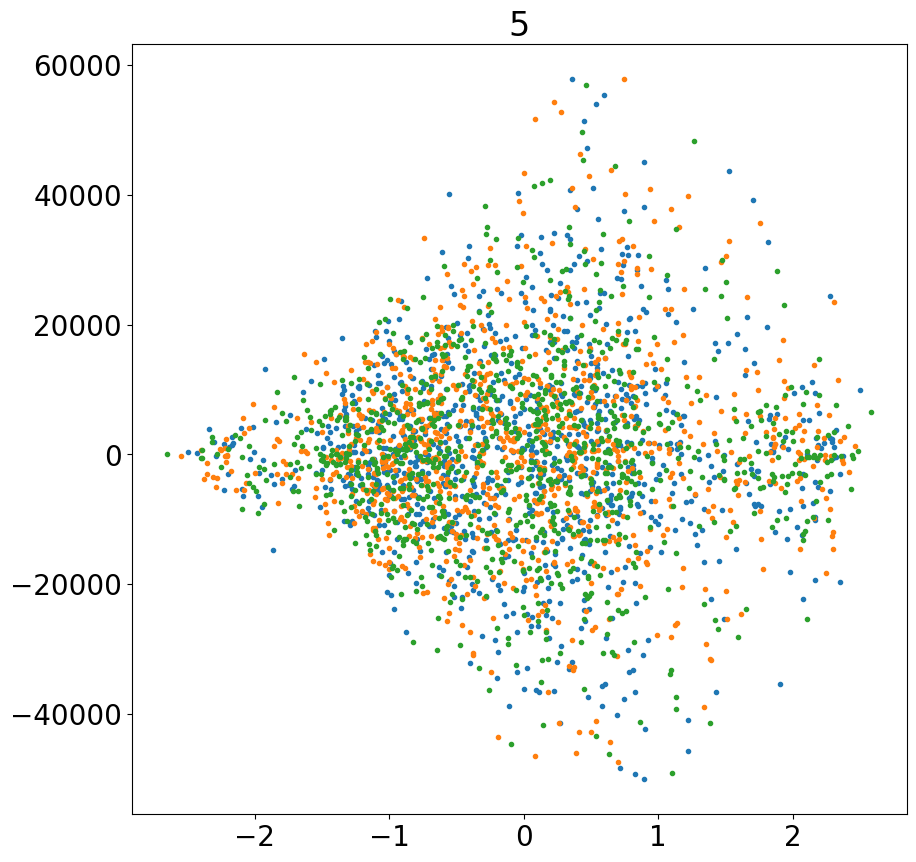

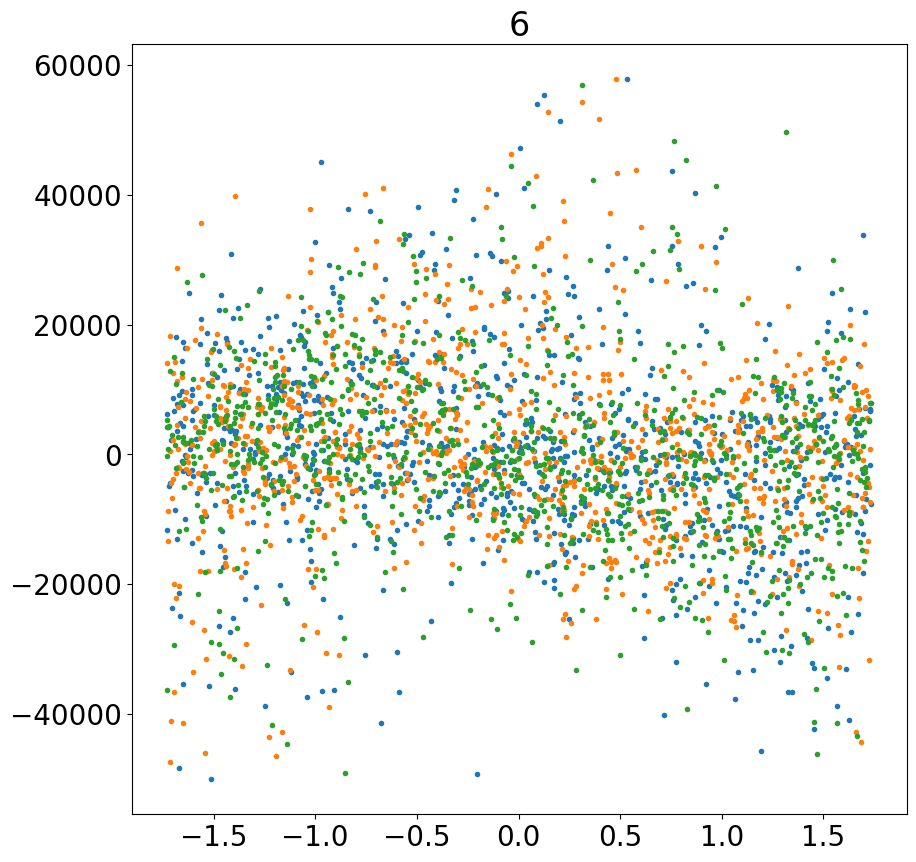

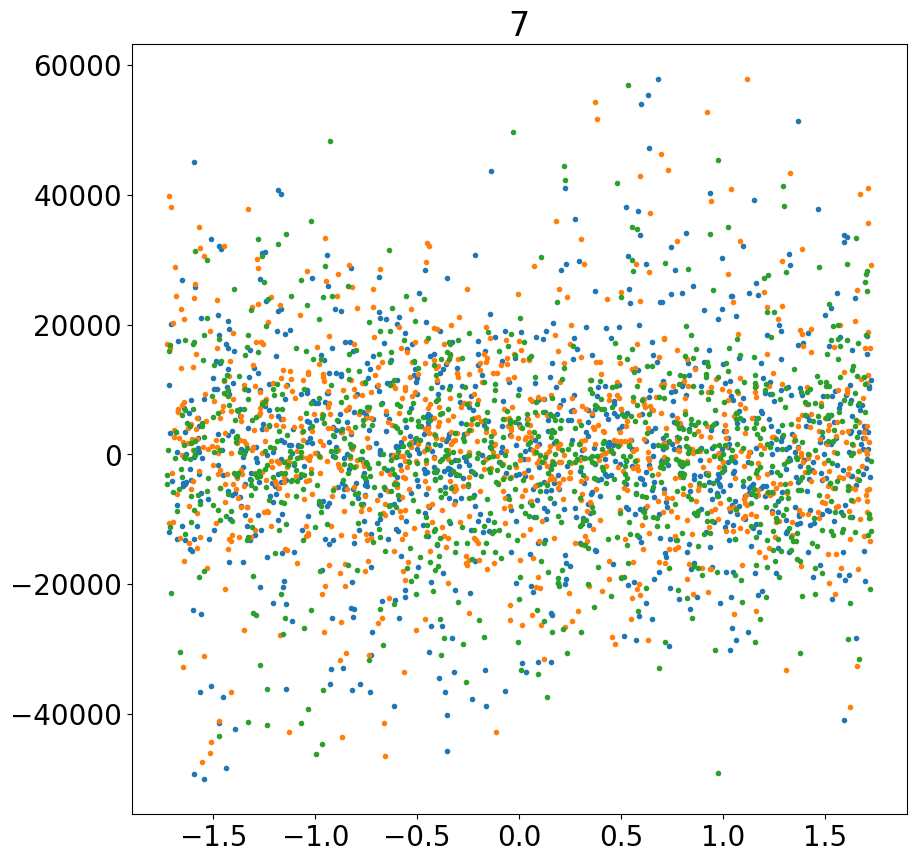

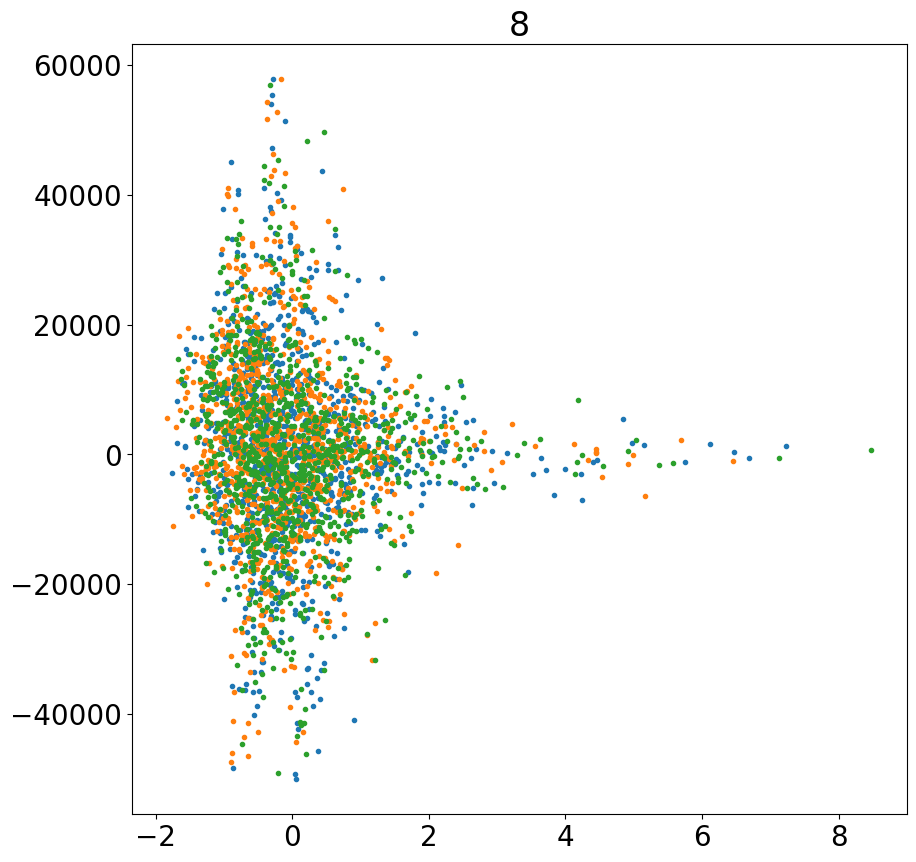

In [15]:
# 学習データ、検証データ、テストデータの確認
for count in range(0,9):
    plt.plot(X_train[:,count],y_train,".")
    plt.plot(X_val[:,count],y_val,".")
    plt.plot(X_test[:,count],y_test,".")
    plt.title(count)
    plt.show()

# Most likely HGPR

In [18]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from gpr import GaussianKernel
from gpr import GaussianProcessRegression

if __name__ == '__main__':
    N_train = train_size 
    N_test = test_size 

#    N_train = 500
#    N_test = 100
#    split_rate = 0.1
#    N_train_1 = int(N_train * (1.0 - split_rate))
#    N = N_train + N_test

#    mu_test_ave = np.zeros(N_test)
#    sigma_test_ave = np.zeros(N_test)
    count = 1

#    x_train_ = 
#    x_test_ = np.arange(0.0, 1.0, 1 / N_test)
#    mu_train = 2.0 * (np.exp(-30.0 * (x_train_ - 0.25) ** 2.0) + np.sin(np.pi * x_train_) ** 2) - 2.0
#    g_train = np.sin(2.0 * np.pi * x_train_)
#    t_train_ = np.random.normal(mu_train, np.exp(g_train))
#    x_test_ = np.arange(0.0, 1.0, 1 / N_test)

    r_train_ = np.identity(N_train) * 0.01
    r_test_ = np.identity(N_test) * 0.01
    var_r_train_ = np.identity(N_train) * 0.01
    var_r_test_ = np.identity(N_test) * 0.01

    print(r_train_)

    cnt = 0
    broke_num = 0
    while cnt < count:
        print(cnt)

        # x_train_1, x_train_2, t_train_1, t_train_2 = train_test_split(x_train_, t_train_, test_size=split_rate)

        try:
            kernel_ = GaussianKernel(param_=np.array([1., 1.]))
#            kernel_ = RationalQuadratic(length_scale=0.3, alpha=2.0)
            regression = MostLikelyHGPR(kernel=kernel_, x_train=X_train, x_test=X_test, t_train=y_train \
                                        , r_train=r_train_, r_test=r_test_, var_r_train=var_r_train_, var_r_test=var_r_test_)
            regression.fit(learning_rate_gpr=0.1, max_iter_sampling=1000, max_iter_gpr=1, sampling_num=5000)
            cnt += 1
        except:
            print('Error')
            broke_num += 1
            if broke_num < 5 * count:
                continue
            else:
                break

        y_pred_train, sigma_train_ = regression.predict(X_train)
        y_pred_val, sigma_val_ = regression.predict(X_val)
        y_pred_test, sigma_test_ = regression.predict(X_test)

        sigma_test_ = np.sqrt(sigma_test_)
        sigma_test_diag = np.diag(sigma_test_)
        sigma_test_diag.flags.writeable = True
        sigma_test_diag[np.isnan(sigma_test_diag)] = 0
#        y_test_ave += y_test_        
#        sigma_test_ave += sigma_test_diag

#    y_test_ave /= cnt
#    sigma_test_ave /= cnt

# アンサンブルの回帰結果の可視化処理
plt.plot([-8e4, 8e4],[-8e4, 8e4], "-", color="gray", linewidth=5)
plt.plot(y_train, y_pred_train, ".", color="black", label="train")
plt.plot(y_val, y_pred_val, ".", color="blue", label="val")
plt.plot(y_test, y_pred_test, ".", color="red", label="test")

plt.legend()
plt.xlim(-8e4, 8e4)
plt.ylim(-8e4, 8e4)
plt.xlabel("Data")
plt.ylabel("Predict")
plt.show()

    
    # x_test_ = np.arange(0.0, 1.0, 1 / N_test)
#    mu_test = 2.0 * (np.exp(-30.0 * (x_test_ - 0.25) ** 2.0) + np.sin(np.pi * x_test_) ** 2) - 2.0
#    g_test = np.sin(2.0 * np.pi * x_test_)
#    t_test_ = np.random.normal(mu_test, np.exp(g_test))
#    g_test = np.sqrt(np.exp(g_test))

#    print(sigma_test_ave)

#    fig1 = plt.figure()
#    plt.fill_between(x_test_, mu_test_ave - sigma_test_ave*2, mu_test_ave - sigma_test_ave*3 \
#                     , color="c", alpha=0.2)
#    plt.fill_between(x_test_, mu_test_ave + sigma_test_ave * 2, mu_test_ave + sigma_test_ave * 3 \
#                 , color="c", alpha=0.2)
#    plt.fill_between(x_test_, mu_test_ave - sigma_test_ave, mu_test_ave - sigma_test_ave * 2 \
#                     , color="c", alpha=0.4)
#    plt.fill_between(x_test_, mu_test_ave + sigma_test_ave, mu_test_ave + sigma_test_ave * 2 \
#                     , color="c", alpha=0.4)
#    plt.fill_between(x_test_, mu_test_ave - sigma_test_ave, mu_test_ave + sigma_test_ave, color='c', alpha=0.6)
#    plt.scatter(x_test_, t_test_, color='g', s=10)
    # plt.scatter(x_train_, t_train_, color='r')
#    plt.plot(x_test_, mu_test, color='r')
#    plt.plot(x_test_, mu_test + g_test, color='hotpink')
#    plt.plot(x_test_, mu_test - g_test, color='hotpink')
#    plt.plot(x_test_, mu_test + g_test * 2, color='violet')
#    plt.plot(x_test_, mu_test - g_test * 2, color='violet')
#    plt.plot(x_test_, mu_test + g_test * 3, color='lightpink')
#    plt.plot(x_test_, mu_test - g_test * 3, color='lightpink')
#    plt.plot(x_test_, mu_test_ave, color='b')
#    plt.ylim(-7.0, 7.0)
#    plt.savefig('test_most_likely_hgpr.png')
#    plt.show()

[[0.01 0.   0.   ... 0.   0.   0.  ]
 [0.   0.01 0.   ... 0.   0.   0.  ]
 [0.   0.   0.01 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.01 0.   0.  ]
 [0.   0.   0.   ... 0.   0.01 0.  ]
 [0.   0.   0.   ... 0.   0.   0.01]]
0


TypeError: MostLikelyHGPR.predict() takes 1 positional argument but 2 were given

# ガウス過程回帰

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.metrics import mean_squared_error

import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from gpr import GaussianKernel
from gpr import GaussianProcessRegression
import time

# set start time
start_time = time.time()

# カーネル関数の設定
#kernel = RationalQuadratic(length_scale=0.3, alpha=2.0)
kernel_ = GaussianKernel(param_=np.array([1., 1.]))

# ガウス過程回帰モデルを適合させる
#gpr_model = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train)
#print(gpr_model.kernel_)

gpr_hgpr = MostLikelyHGPR(kernel=kernel_, x_train=X_train_, x_test=X_test_, t_train=t_train_ \
                                        , r_train=r_train_, r_test=r_test_, var_r_train=var_r_train_, var_r_test=var_r_test_)
gpr_model.fit(learning_rate_gpr=0.1, max_iter_sampling=500, max_iter_gpr=1000, sampling_num=5000)


# 各モデルの予測を取得
y_pred_train = gpr_model.predict(X_train)
y_pred_val = gpr_model.predict(X_val)
y_pred_test = gpr_model.predict(X_test)

# 評価スコアを計算
score_val = gpr_model.score(X_val, y_val)
score_test = gpr_model.score(X_test, y_test)

# Calculate Mean Squared Error
mse_val = mean_squared_error(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)

# Show score for validation and test data（任意）
print("Validation Score:", score_val)
print("Test Score:", score_test)

# 検証データでの精度評価 using log_marginal_likelihood
log_marginal_likelihood_val = gpr_model.log_marginal_likelihood()
print("Log Marginal Likelihood:", log_marginal_likelihood_val)

# アンサンブルの回帰結果の可視化処理
plt.plot([-8e4, 8e4],[-8e4, 8e4], "-", color="gray", linewidth=5)
plt.plot(y_train, y_pred_train, ".", color="black", label="train")
plt.plot(y_val, y_pred_val, ".", color="blue", label="val")
plt.plot(y_test, y_pred_test, ".", color="red", label="test")

plt.legend()
plt.xlim(-8e4, 8e4)
plt.ylim(-8e4, 8e4)
plt.xlabel("Data")
plt.ylabel("Predict")
plt.show()

#set end time
end_time = time.time()
#print elapsed time
elaplsed_time = end_time - start_time 
print(elaplsed_time)

NameError: name 'X_train_' is not defined

In [29]:
#statistics
from scipy.stats import kurtosis, skew

print(y_train.var(), y_train.kurt(), y_train.skew())
print(y_val.var(),y_val.kurt(),y_val.skew())
print(y_test.var(), y_test.kurt(), y_test.skew())
print(y_pred_val.var(), kurtosis(y_pred_val), skew(y_pred_val))
print(y_pred_test.var(), kurtosis(y_pred_test), skew(y_pred_test))

216990877.92142433 1.446311425153636 0.14264968415556803
212456151.09774294 1.4565555491594169 0.1484309777275348
215092952.89942417 1.5041909511932228 0.16625133384930654
183250718.76118815 2.0049191976916463 0.19907328006432964
181995518.7882032 1.8505262183567899 0.2607620069749324


In [85]:
#説明変数組み合わせ行列の生成
data_dim = 9 #説明変数の次元数
min_dim = 1 # minimum dimension to treat

selection_ar = np.zeros([data_dim,2**(data_dim)-1])
coeff_ar = np.zeros([data_dim+1,2**(data_dim)-1])
indicator_ar = np.zeros([data_dim+1,2**(data_dim)-1])
id_ar = np.arange(data_dim)
brute_ar = np.zeros([data_dim,2**(data_dim)-1])
model_num_count = 0


for count_term in range(data_dim,min_dim-1, -1):
    id_combination = list(itertools.combinations(id_ar,count_term))
    print(len(id_combination))
    for count_model in range(0,len(id_combination)):
        selection_ar[np.array(id_combination[count_model]),model_num_count] = 1
        model_num_count += 1

print('total model number is ',model_num_count)
print(len(selection_ar.T))

1
9
36
84
126
126
84
36
9
total model number is  511
511


In [86]:
selection_ar.T

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [87]:
column_name = ['t_0-t_2', 't_1-t_0', 'r0', 'z0', 'r1', 'z1', 'tt_0', 'tt_1', 'tin']
print(column_name)

['t_0-t_2', 't_1-t_0', 'r0', 'z0', 'r1', 'z1', 'tt_0', 'tt_1', 'tin']


In [89]:
#check shape
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (10000, 9)
y_train shape: (10000,)
X_val shape: (10000, 9)
y_val shape: (10000,)
X_test shape: (10000, 9)
y_test shape: (10000,)


In [90]:
print("selection_ar shape:", selection_ar.shape)

selection_ar shape: (9, 511)


In [98]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.metrics import mean_squared_error
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from multiprocessing import Pool, Manager
import itertools


# カーネル関数の設定
kernel = gp.kernels.RationalQuadratic(length_scale=0.35, alpha=2.0) 

# 説明変数の次元数
data_dim = 9

# Managerオブジェクトを使用して共有変数を定義
manager = Manager()
score_res = manager.list()

# 説明変数の組み合わせ行列を生成
id_ar = np.arange(data_dim)

# プールのスレッド数
num_threads = 20

# 並列処理関数
def process_combination(i):
    X_train_i = selection_ar.T[i] * X_train
    X_val_i = selection_ar.T[i] * X_val
#    X_test_i = selection_ar.T[i] * X_test
    
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train_i, y_train)
    score_val = gpr.score(X_val_i, y_val)
    
    y_pred_train = gpr.predict(X_train_i, return_std=True)
    y_pred_val = gpr.predict(X_val_i, return_std=True)
#    y_pred_test = gpr.predict(X_test_i, return_std=True)

    mse_val = mean_squared_error(y_val, y_pred_val[0])

    log_marginal_likelihood_val = gpr.log_marginal_likelihood()

    result = []
    for j in range (data_dim):
        result.append(selection_ar.T[i,j])
    result.append(score_val)
    result.append(mse_val)
    result.append(log_marginal_likelihood_val)
    result.append(y_pred_val[0].var())
    result.append(kurtosis(y_pred_val[0]))
    result.append(skew(y_pred_val[0]))
    score_res.append(result)

    print(f"Validation Score for combination {selection_ar.T[i]}:", score_val, mse_val, log_marginal_likelihood_val, y_pred_val[0].var(), kurtosis(y_pred_val[0]), skew(y_pred_val[0]))
    
# make plot
    plt.rcParams['figure.figsize'] = 10, 10
    plt.rcParams["font.size"] = 20
    plt.figure()
    f_name = './plt/GPR_1000keV_' + ''.join(map(lambda x: '1' if x == 1 else '0', selection_ar.T[i])) + '.png'
    plt.plot([-8e4, 8e4], [-8e4, 8e4], "-", color="gray", linewidth=5)
    plt.plot(y_train, y_pred_train[0], ".", color="black", label="train")
    plt.plot(y_val, y_pred_val[0], ".", color="red", label=f"Validation Score: {score_val:.2f}")
#    plt.plot(y_test, y_pred_test[0], ".", color="blue", label="test")
    plt.legend()
    plt.xlim(-8e4, 8e4)
    plt.ylim(-8e4, 8e4)
    plt.xlabel("True")
    plt.ylabel("Predict")
    plt.savefig(f_name)
    plt.close()

# ガウス過程回帰を並列処理で実行
with Pool(num_threads) as p:
    p.map(process_combination, range(model_num_count))
#    p.map(process_combination, range(20) )

# score_resをnumpy配列に変換
score_res_array = np.array(score_res)
print(score_res_array.shape)

Validation Score for combination [1. 0. 1. 0. 1. 1. 1. 1. 0.]: 0.9219419915963492 16582245.63739216 -271632005865.58862 177883599.14937547 2.131093301583766 0.19349123467312043
Validation Score for combination [1. 1. 0. 1. 1. 0. 1. 1. 1.]: 0.9322622012020226 14389872.885249939 -260788713427.54517 179897157.44052297 2.0457620103795806 0.19228883151900197
Validation Score for combination [0. 1. 1. 1. 0. 1. 1. 1. 1.]: 0.9150093154847756 18054988.031895984 -298965255297.3916 174980044.20420384 2.0898558313367426 0.19442621161629697
Validation Score for combination [1. 1. 1. 1. 1. 1. 1. 1. 1.]: 0.9408981727052002 12555291.095221706 -242819820243.70538 183250725.64127827 2.0049190964502825 0.19907327666636732
Validation Score for combination [1. 1. 0. 1. 1. 1. 1. 1. 1.]: 0.9335211728894748 14122423.35382074 -263187306100.5273 180531690.4337281 2.0139852559966114 0.19586010526589562
Validation Score for combination [0. 1. 1. 0. 1. 1. 1. 1. 0.]: 0.9203172903020935 16927388.903274868 -278441550

/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 1. 1. 0. 0. 1. 0. 0. 1.]: 0.9184054588037837 17333528.64691705 -323085560369.4522 175267885.56016156 2.1366395073975113 0.1957319257888046
Validation Score for combination [0. 0. 1. 1. 1. 1. 0. 0. 1.]: 0.5145616450814618 103124051.04476458 -737972576665.9292 73831401.41629389 3.215560696650731 0.259493021942038
Validation Score for combination [1. 0. 1. 0. 1. 1. 0. 0. 0.]: 0.0003205818942328964 212366802.69823238 -1085289542549.9404 6937.3870160108145 0.236452184999576 0.644176090623606
Validation Score for combination [1. 0. 0. 0. 0. 1. 1. 0. 1.]: 0.8324226185766282 35599285.18370114 -441570665005.03375 148591056.19316393 2.253446247150589 0.16243716210946196
Validation Score for combination [0. 1. 1. 1. 0. 0. 0. 0. 1.]: 0.9272749510139451 15449338.907572448 -305160777764.6541 177865543.22888735 2.051387648226095 0.19000728861439412
Validation Score for combination [1. 0. 0. 0. 1. 1. 1. 0. 0.]: 0.9487661911063168 10883849.349844886 -224863708435.23

/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 1. 0. 0. 0. 0. 1. 1. 1.]: 0.11095902722169715 188863335.02234703 -1.5747479983641298e+16 15542806.355506415 -0.06235121683626543 0.10882804227680344
Validation Score for combination [1. 0. 0. 0. 1. 0. 1. 0. 1.]: 0.6287407043776988 78868433.37507252 -584518746744.5219 104985461.92520386 1.5929904349731308 0.21434500078367724
Validation Score for combination [0. 1. 0. 0. 1. 0. 1. 0. 1.]: 0.4821011890093483 110019784.9623672 -696531901859.0952 78157824.47993807 0.6106437459600831 0.12187921053245997
Validation Score for combination [1. 1. 0. 0. 0. 1. 0. 1. 0.]: 0.7134203492245523 60879521.02572823 -634624714282.322 115667660.06548266 3.0903156459477055 0.11406911323895826
Validation Score for combination [1. 0. 1. 1. 0. 1. 0. 0. 0.]: 0.0003086691287220722 212369333.3854477 -1085255484012.1056 8144.302458834437 0.5898643332294657 0.7841319874101726
Validation Score for combination [0. 0. 1. 1. 0. 0. 1. 1. 0.]: 0.5170878626974746 102587394.24427836 -7013

/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [1. 1. 1. 0. 0. 0. 0. 0. 0.]: 0.0007969370395417563 212265608.2379625 -1085308259535.9998 10798.403105318086 0.3132527976996835 0.7222253305975743
Validation Score for combination [1. 0. 0. 1. 0. 0. 1. 0. 1.]: 0.8604457687487068 29646189.92556999 -407783601196.1688 153649173.89567754 2.1488931823404878 0.19379431947037193
Validation Score for combination [0. 1. 1. 1. 1. 0. 0. 0. 0.]: 0.001975323951506125 212015277.7256974 -1084609688048.0776 205430.06608437392 157.71280488575061 2.3894284251081666
Validation Score for combination [1. 0. 0. 1. 1. 1. 0. 0. 0.]: 0.00048313100706742773 212332271.59281108 -1084943355261.717 85919.44438879327 28.333423563769674 0.9429486211139119
Validation Score for combination [0. 1. 0. 1. 0. 0. 1. 1. 0.]: 0.21417705745595406 166936222.52542907 -926604529389.1443 31739578.291566193 1.3989358511400711 0.16322394000915733
Validation Score for combination [1. 0. 1. 0. 0. 1. 1. 0. 0.]: 0.9386028470245219 13042898.389248457 -243

/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 1. 1. 1. 1. 0. 0. 0.]: 0.00026857436542082613 212377850.91269994 -1085341183498.6981 8631.812691303781 1.014820788405653 0.774951592187328
Validation Score for combination [1. 0. 1. 0. 0. 0. 0. 0. 1.]: 0.4148147747743782 124313768.01063839 -773418705194.0977 64038120.198239 2.1856559613698225 0.10113942298130664
Validation Score for combination [1. 0. 0. 1. 1. 0. 1. 0. 0.]: 0.9538337049215568 9807332.531472439 -210647136266.661 188288274.556398 1.7967210982317043 0.17324536778319444
Validation Score for combination [0. 1. 0. 0. 1. 0. 0. 1. 1.]: 0.46460441627455495 113736710.22453412 -739540884633.0116 69666816.81407139 1.070180351517573 0.21538504288383054
Validation Score for combination [1. 0. 0. 0. 0. 1. 0. 0. 1.]: 0.14111190413174524 182457811.4659315 -1004508818400.974 15939360.83428981 2.3264924838269847 -0.3800851547484491
Validation Score for combination [1. 0. 0. 0. 1. 0. 0. 1. 1.]: 0.4915239233963953 108018067.27346691 -738391940083.002

/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 1. 0. 0. 1. 0. 0. 0.]: -0.001962895903851125 212851893.08844003 -3.1024622288418904e+16 1214630.636961237 7.227230645284752 0.28788039414397426


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [1. 0. 0. 0. 1. 0. 0. 0. 0.]: -0.010330943503095602 214629558.48925972 -7.051645389334042e+18 3363537.211059953 36.41319290671993 1.807464466878536
Validation Score for combination [0. 1. 0. 0. 1. 1. 0. 0. 0.]: 0.0015993120062098853 212095155.78775674 -1084932115103.9644 103215.10863473944 75.30369978493465 1.752425448773711
Validation Score for combination [0. 0. 0. 1. 0. 0. 0. 1. 0.]: 0.018758068395465233 208450036.99600577 -1075779217849.7692 1842415.5054661206 0.40511230053594716 0.1786463661038791


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [1. 1. 0. 0. 1. 0. 0. 0. 0.]: 0.003967020621782447 211592171.83179718 -1084292812644.0189 287945.0675059938 315.34419124253776 -5.761480155057044
Validation Score for combination [0. 0. 1. 1. 0. 0. 0. 0. 1.]: 0.5038726389543687 105394769.0510769 -758396397518.7599 63183133.35364882 2.9898019048224143 0.258937600006558
Validation Score for combination [0. 1. 0. 0. 1. 0. 0. 0. 0.]: -0.002020936001392748 212864222.8310755 -4.615873115791225e+18 371035.50810720056 985.797385594994 5.519145624511576
Validation Score for combination [0. 0. 1. 0. 0. 1. 0. 0. 1.]: 0.5184192205162124 102304567.37189123 -733122704146.5374 72318312.55849676 3.0664683265447126 0.2467574530743669
Validation Score for combination [1. 0. 1. 1. 0. 0. 0. 0. 0.]: 0.00041169738817214974 212347446.5868894 -1085146856320.8197 47483.95499207976 18.397452553111897 0.5234428646478593
Validation Score for combination [1. 0. 0. 0. 1. 0. 0. 1. 0.]: 0.47226078074099975 112110231.16276436 -75482683

/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 1. 0. 0. 0. 0. 1. 0. 1.]: 0.1176831642130387 187434893.6161391 -1.5747463926788596e+16 19231998.793469008 -0.14064606493388343 0.17587352215074484
Validation Score for combination [1. 0. 0. 0. 0. 0. 1. 0. 1.]: 0.46912725847356973 112775900.66947356 -724384085052.858 73119689.32539602 0.856888988314152 0.13618376590290082
Validation Score for combination [0. 1. 1. 0. 0. 0. 0. 0. 1.]: 0.3940237922580131 128730498.41639349 -794946117737.2776 58888875.280633494 1.0295979390831356 0.0867867038646727
Validation Score for combination [0. 0. 0. 0. 0. 1. 1. 0. 1.]: 0.23171927665888636 163209642.84709853 -917777702158.5707 34537928.517083175 0.4948834298473992 0.07764626120204692
Validation Score for combination [1. 0. 0. 1. 0. 1. 0. 0. 0.]: 0.000332839848016242 212364198.680979 -1085213255274.2482 24025.307672884996 3.874793709478924 0.912174100495183
Validation Score for combination [0. 0. 1. 0. 0. 0. 1. 0. 0.]: 0.16003072667299756 178438793.18753785 -95348

/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [1. 0. 0. 0. 0. 1. 0. 0. 0.]: -1.1037923646206593e-06 212435139.9666598 -1085546077767.6251 10642.575969023808 1728.511300471233 -26.31497860704126


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

Validation Score for combination [0. 0. 1. 0. 0. 0. 0. 0. 0.]: -0.20038680740437598 255004057.97354838 -8.465477071303165e+21 45242136.13661057 7.052218585538883 0.46417323229254664


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 1. 0. 0. 1. 0. 1. 0. 0.]: 0.47429596722498124 111677886.5144002 -706143154742.2067 76306226.3606194 0.5722642956880266 0.11420646287883597
Validation Score for combination [0. 0. 0. 1. 0. 0. 0. 0. 1.]: 0.04110531634506409 Validation Score for combination [0. 0. 1. 0. 1. 1. 0. 0. 0.]:203702701.49003574  -1064735666345.40010.00031685483154142435 4203238.837759462 212367594.45644298  1.8710082610189698-1085337373472.7577  9404.253245703740.23273551486386201
 1.1469365627394215 0.7403222440184448


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 1. 0. 0. 0. 1. 0. 0. 0.]: 0.000263997689856188 212378823.15834093 -1085370082420.6094 20443.089765927907 449.7629997470622 -9.166957515344443


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [1. 0. 1. 0. 1. 0. 0. 0. 0.]: 0.00013930791085081662 212405311.6197586 -1085481486553.4343 3061.2206880602002 9.211966360769617 0.022351948093080252
Validation Score for combination [0. 0. 0. 0. 0. 1. 0. 0. 1.]: 0.05262576478501002 201255356.1145783 -1057706824873.4106 5304209.06329104 0.09004961195173866 -0.06541569855680264
Validation Score for combination [0. 0. 1. 0. 0. 0. 1. 1. 0.]: 0.2530252548031826 158683509.3937999 -892960545565.8175 37159494.804738395 -0.07142713337552564 0.08782125867394854
Validation Score for combination [0. 0. 0. 0. 1. 1. 0. 1. 0.]: 0.24822354765532073 159703559.59791124 -919287637308.322 34038596.851524934 1.5150476237382406 0.09606442419551922
Validation Score for combination [0. 0. 0. 1. 0. 1. 1. 0. 0.]: 0.2759041894517984 153823225.07417786 -893996759400.1246 39030772.26443137 -0.017009268152683443 0.13738986079810503
Validation Score for combination [1. 0. 0. 0. 0. 0. 0. 1. 1.]: 0.04426478359744668 203031520.36290038 

/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 1. 0. 0. 0. 0. 0. 1. 1.]: 0.039768080858744836 203986776.98418 -2.074071879420425e+17 1202546.7563861455 0.3118800956805394 0.2707325815509668
Validation Score for combination [0. 0. 1. 0. 1. 0. 1. 0. 0.]: 0.2081135517121685 168224322.79500356 -920731998156.3956 32411134.54031177 -0.7715359161534816 0.12361945513799956
Validation Score for combination [0. 1. 0. 0. 1. 0. 0. 1. 0.]: 0.46821044414725643 112970664.03422906 -735926221716.6102 70518910.39252374 1.0999442571038172 0.157302946569426
Validation Score for combination [1. 0. 1. 0. 0. 1. 0. 0. 0.]: 0.0002674704479977974 212378085.42329335 -1085264574839.3154 8056.8240339479025 0.616102981306307 0.7683735135203442
Validation Score for combination [0. 0. 1. 0. 0. 0. 1. 0. 1.]: 0.40107085723689107 127233455.83367556 -760122771745.479 64690577.341676585 0.35086508691752494 0.09681054002005986


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 0. 0. 1. 1. 0. 0. 0.]: -0.009226169573712362 214394865.9439915 -6.988879708044316e+17 3069550.474204164 7.085566558750989 0.8938294976570613
Validation Score for combination [0. 0. 0. 0. 1. 1. 0. 0. 1.]: 0.5245408405387082 101004121.60101174 -720471604174.2024 76186940.93675828 3.06528295433933 0.26485149233142774
Validation Score for combination [1. 0. 0. 0. 0. 1. 1. 0. 0.]: 0.2207216554215653 165545921.47518262 -913070078756.0916 35873257.77795881 0.012273764006757837 0.11890883889157959


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [1. 0. 0. 0. 0. 0. 0. 1. 0.]: 0.017680195987409886 208679014.71913332 -1076556773118.671 1707566.2527823418 1.4382640301064251 0.1898584833210098
Validation Score for combination [0. 0. 0. 0. 0. 0. 1. 1. 1.]: 0.10853801041297984 189377643.49927875 -1.5747481745696514e+16 14684054.074443396 -0.056458669117521065 0.10947671034848254


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 0. 1. 0. 1. 0. 1. 0.]: 0.13242076984725915 184304111.75619316 -1017252974000.4218 14141030.72330081 4.335105812122562 -0.035322370865985726


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 1. 0. 0. 0. 0. 1. 0. 0.]: 0.11675612017692305 187631830.12832958 -1.5747463794989366e+16 19173436.227884125 -0.18776433622152533 0.16737243493887335
Validation Score for combination [0. 0. 0. 1. 0. 0. 0. 0. 0.]: -0.2094241603602267 256923907.19453776 -2.9321820022669522e+20 46921464.61426538 5.410812585340796 0.02771662727987444
Validation Score for combination [0. 1. 1. 1. 0. 0. 0. 0. 0.]: 0.0016152336270920387 212091773.4797295 -1084527363743.5548 197078.29883177485 52.0365466623022 -0.598151637619353


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 1. 1. 1. 0. 0. 0. 0.]: 0.0002888232491020659 212373549.343009 -1085352524487.9923 8587.649286374994 1.572789708656999 0.7492935361481988


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [1. 0. 0. 1. 0. 0. 0. 1. 0.]: 0.04671329946581393 202511370.12583107 -1060477303633.6666 4948849.35441892 2.552754723679657 0.2978195178046732
Validation Score for combination [0. 0. 1. 0. 0. 0. 0. 0. 1.]: 0.24086023501314002 161267784.22309196 -4.2730073453268275e+18 59120980.89295229 1.24744489565171 0.4929615002282354


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 0. 0. 0. 0. 1. 1. 0.]: 0.05881312988228704 199940943.7949517 -1.5747497906604996e+16 8736634.400762003 -0.7438031462689723 0.013669976837291578
Validation Score for combination [0. 1. 0. 0. 1. 0. 0. 0. 1.]: 0.47059931583235093 112463184.30359587 -732249683831.9899 71569136.62259676 1.1651089179609055 0.16029092289268795
Validation Score for combination [0. 1. 0. 1. 0. 1. 0. 0. 0.]: 0.0009283112529618887 212237699.76935175 -1084882625173.2147 134235.7292299227 121.21157222047101 -1.4761668907959289
Validation Score for combination [0. 0. 1. 0. 1. 0. 0. 1. 0.]: 0.1598846180742498 178469831.75390303 -971404734977.8444 22911022.57202006 0.09118737308420144 0.16529867869122333
Validation Score for combination [0. 0. 0. 0. 1. 0. 1. 0. 0.]: 0.17956355304596294 174289339.06318825 -939384035324.8181 28719286.98368191 -0.9198411485300886 0.11359739350129895
Validation Score for combination [0. 0. 0. 0. 1. 0. 1. 1. 0.]: 0.2960973420740085 149533494.60548228

/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

Validation Score for combination [1. 0. 0. 0. 0. 0. 0. 0. 1.]: 0.048782800584496466 202071735.8512875 -1057726672470.7354 5293971.21798181 1.06213379132274 -0.17649128085038812
Validation Score for combination [0. 0. 0. 0. 1. 0. 0. 0. 0.]: -0.3060565095154839 277451991.1538996 -7.749132199640274e+21 65221407.883684695 3.969125069087937 0.30887401182354857


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [1. 0. 0. 0. 0. 1. 0. 1. 0.]: 0.07713764657151423 196048176.8240608 -1038714906504.0703 9391955.344736025 2.3255723390037524 0.1903899491996252


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 1. 1. 0. 1. 0. 0. 0. 0.]: 0.0004064910485132023 212348552.59516275 -1085449827359.4404 5320.367115086206 0.8229873240250489 0.7485773431537871
Validation Score for combination [1. 1. 0. 0. 0. 0. 0. 0. 0.]: -0.0006326246502910138 212569297.04042375 -3321149633374210.5 73311.64767673679 7238.851065986134 -76.77771663033246


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 0. 1. 0. 1. 0. 0. 1.]: 0.4076673361393398 125832133.46151568 -848053012170.3573 50988813.69166915 3.239135813459167 0.34613196141521096Validation Score for combination [0. 0. 0. 0. 0. 0. 1. 0. 1.]:
 0.11361392534982284 188299341.9894326 -1.5747473098968902e+16 16857117.33777884 -0.2659131954433791 0.16290761651394006
Validation Score for combination [0. 0. 0. 1. 1. 0. 0. 0. 0.]: 0.00025679946474377324 212380352.31261235 -1085355926656.9109 14089.065178305176 42.320487605793964 1.744799546352657


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Validation Score for combination [0. 0. 1. 0. 0. 0. 0. 1. 1.]: 0.22666037338036604 164284330.48691678 -1.1553638458990518e+16 28160615.49045128 0.7927124172482265 0.5585163699194087


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 1. 0. 0. 0. 0. 0. 1. 0.]: 0.09588677590806993 192065207.30556792 -2.074075802404382e+17 10277431.640721215 0.10858798028873418 0.2017690035764451
Validation Score for combination [0. 1. 0. 0. 0. 1. 1. 0. 0.]: 0.23461883170280973 162593676.14540097 -913461885336.1417 35363993.88316314 0.4966152417533287 0.0786759567035222


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 1. 1. 0. 0. 0. 0. 0. 0.]: -0.007864632098485869 214105627.8591307 -2.583075397460262e+19 1323777.4039126963 670.9598331776522 -12.989047677009786
Validation Score for combination [0. 0. 1. 1. 0. 1. 0. 0. 0.]: -8.469030923885512e-06 212436704.60041705 -1085220918827.3456 42537.62701495511 52.65608917184384 -0.04082804704672652
Validation Score for combination [0. 1. 0. 1. 0. 0. 1. 0. 0.]: 0.2253546829794859 164561704.70381734 -913242247340.5333 34905614.09030238 0.8813956649271071 0.17491846760884763
Validation Score for combination [0. 0. 1. 0. 1. 0. 0. 0. 1.]: 0.3359803184740262 141060958.28357843 -852415024279.8151 47519697.27044805 1.2360640679284796 0.5229785756652507


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 0. 0. 1. 0. 0. 1. 0.]: 0.13975507242036367 182746049.88229468 -990786109072.852 18658918.82439729 -0.25744645741840166 0.14910936691251134
Validation Score for combination [0. 0. 0. 0. 0. 1. 0. 0. 0.]: -0.13993719209134192 242162449.6580625 -7.484635230215386e+20 27245890.195195295 15.444806908713325 0.5101132152723231


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 0. 0. 1. 0. 1. 0. 1.]: 0.477028812764938 111097334.73042084 -701007982540.8857 77311540.52511933 0.5177220637181823 0.11576456948449897
Validation Score for combination [0. 0. 0. 1. 0. 1. 0. 0. 0.]: 0.0002520526654136157 212381360.69847938 -1085292552622.4794 53823.847288984325 2365.6565823133988 -33.541909458575034


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 0. 1. 1. 1. 0. 0. 0.]: 0.00024717859014777854 212382396.1221978 -1085360631829.2588 9384.769144317974 1.4915291780633728 0.8086733558628028
Validation Score for combination [0. 0. 0. 1. 0. 0. 1. 1. 0.]: 0.11507154585044144 187989692.51615414 -999380538767.5195 17015416.896744862 0.36861808226566284 0.06094740767776454


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better val

Validation Score for combination [1. 0. 1. 0. 0. 0. 0. 0. 0.]: -0.021703559082950852 217045499.0050566 -4.442539012684802e+18 5380948.027195182 5.674030469235378 0.5264832705444493


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 0. 0. 0. 0. 1. 0. 0.]: -0.15452878048674612 245262212.35968164 -9.286735779704485e+20 37547159.34742057 23.74496976903862 1.8248743209567864
Validation Score for combination [0. 0. 0. 0. 0. 0. 0. 1. 1.]: -0.07687773223885941 228766419.26451445 -4.7949369322908215e+20 14093975.966035364 61.656861243397245 0.3677211798178457
Validation Score for combination [0. 0. 1. 1. 0. 0. 1. 0. 0.]: 0.3225018703595057 143924251.13483915 -830696930996.6296 52048030.864963844 0.16895197995053657 0.14227778023131432
Validation Score for combination [0. 1. 1. 0. 0. 1. 0. 0. 0.]: 0.0007717239901448014 212270964.3697281 -1084745443903.1173 189782.14835355425 245.15541727936815 -3.560328363839004
Validation Score for combination [0. 0. 1. 0. 0. 1. 1. 0. 0.]: 0.3195846641096497 144543967.5688007 -839109767730.3562 50545571.44190658 0.0656195151973229 0.14752946888335525
Validation Score for combination [0. 1. 0. 1. 0. 0. 0. 0. 0.]: 0.000772164731274394 212270870.740927

/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 0. 0. 1. 0. 0. 0. 1.]: 0.3122377780728365 146104702.60962278 -2.018592864859625e+18 53659522.36322347 0.8096580578428498 0.512786264296805
Validation Score for combination [0. 0. 0. 0. 1. 0. 0. 1. 1.]: 0.28506464732422243 151877224.07187182 -891000805655.4064 38565697.00216745 1.0505236291470146 0.6059898313106274
Validation Score for combination [0. 0. 0. 1. 1. 0. 1. 0. 0.]: 0.3295671635122087 142423336.2517376 -826014806658.902 52904289.23819549 0.042847078305217945 0.14610334987971055


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 1. 0. 0. 0. 0. 0. 0. 1.]: 0.09048081641121974 193213621.80032423 -4.3616860074852326e+18 33844662.550993 0.26427073729406025 0.11044625919532292
Validation Score for combination [0. 0. 0. 1. 0. 0. 1. 0. 1.]: 0.2226925922306322 165127225.70043626 -918202256351.1393 33862210.15974332 0.8886525252248547 0.1737508221815926


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [1. 0. 0. 1. 0. 0. 0. 0. 0.]: 4.0461768242128215e-05 212426309.990721 -1085280650034.7178 27912.945269147556 11.037564951801368 1.4074093827948122


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [1. 0. 0. 0. 0. 0. 0. 0. 0.]: -0.5016477786885254 319002403.933903 -5.064978209198069e+21 107203887.59570394 3.9777843990722896 0.22680975064803385


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 1. 1. 0. 0. 0. 0. 0.]: -0.0004817238408469926 212537240.44123223 -9.172534720075714e+16 470033.4729211342 16.13122235192208 -0.12149020700266237
Validation Score for combination [0. 0. 0. 0. 0. 1. 1. 0. 0.]: 0.07021172794432395 197519483.69300836 -1033077932919.5428 10342539.344217388 -0.884235795610838 0.021637538391079944


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better val

Validation Score for combination [0. 0. 0. 0. 0. 0. 0. 1. 0.]: -0.2619208167075542 268076029.42383653 -1.1009396180995709e+21 54991193.71963964 7.3114689267513615 0.15823564528312495
Validation Score for combination [0. 1. 0. 0. 0. 0. 0. 0. 0.]: -0.3661908920690595 290226633.02792495 -7.593271503511471e+21 80000584.63161336 3.1144855936592553 -0.07935002411201264


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 0. 0. 0. 0. 0. 0. 1.]: -0.47051067870457364 312387797.0418089 -3.896460355066499e+21 101762153.3441259 5.952586639556644 0.2580107197947478


/home/shinji/python/SPARSE/sparse.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Validation Score for combination [0. 0. 1. 0. 1. 0. 0. 0. 0.]: -0.07250702963925537 227837929.47087485 -2.3167881340413385e+20 17728763.229987733 20.474274171847718 0.7441447191488555
(511, 15)


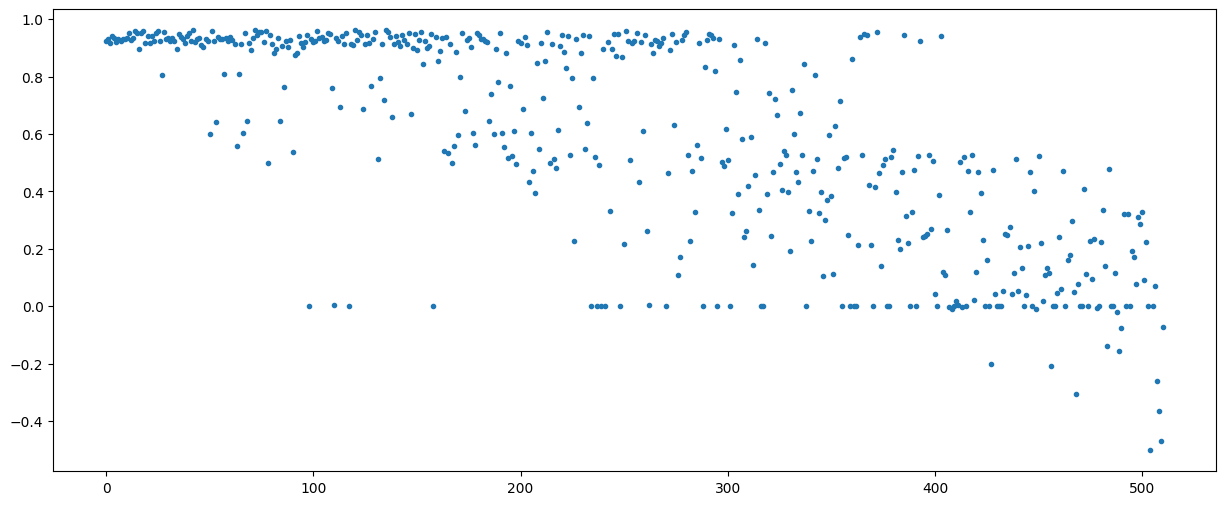

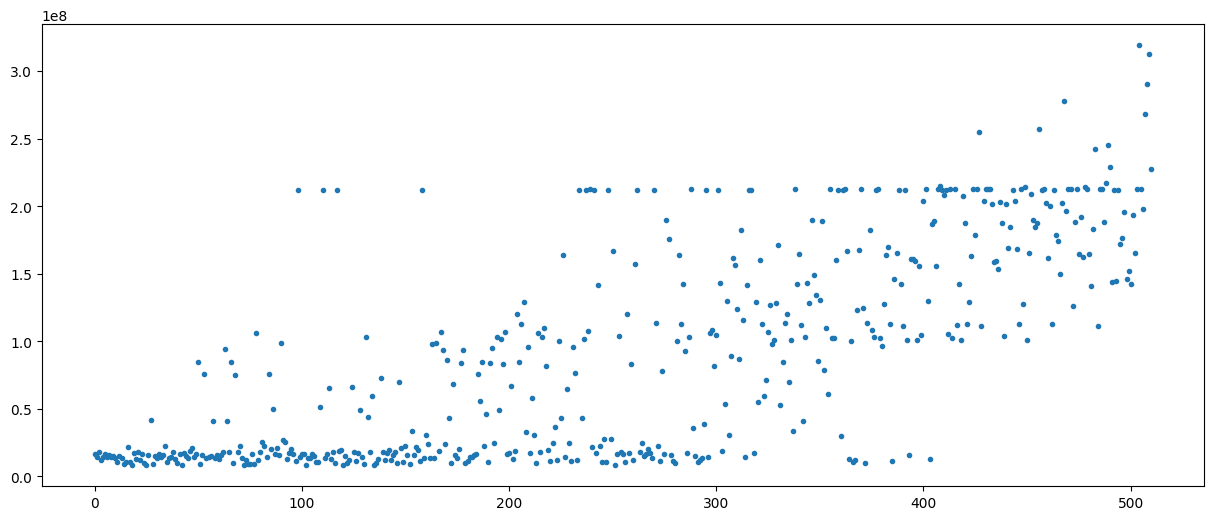

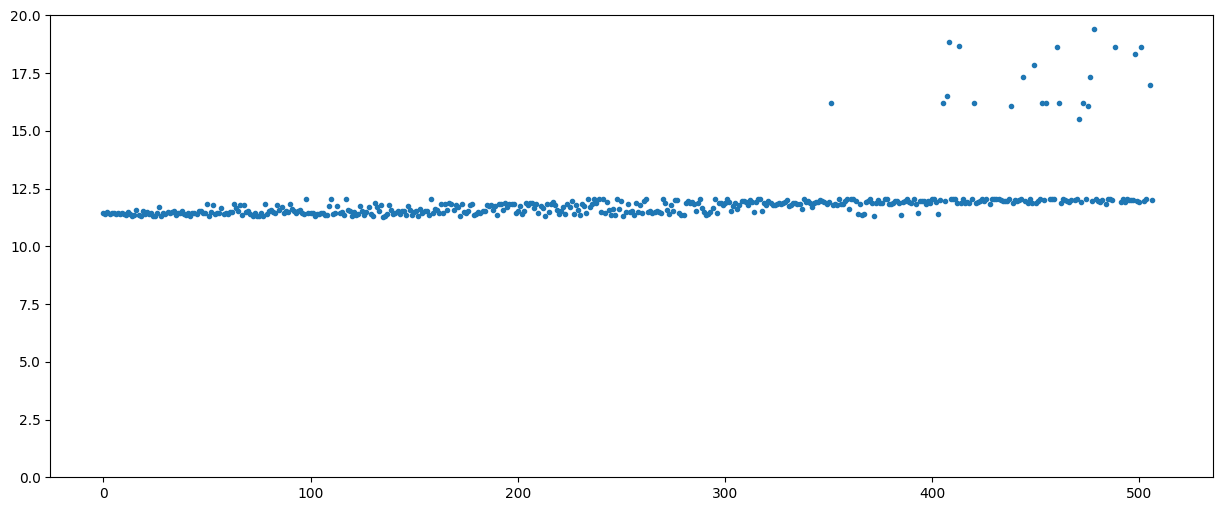

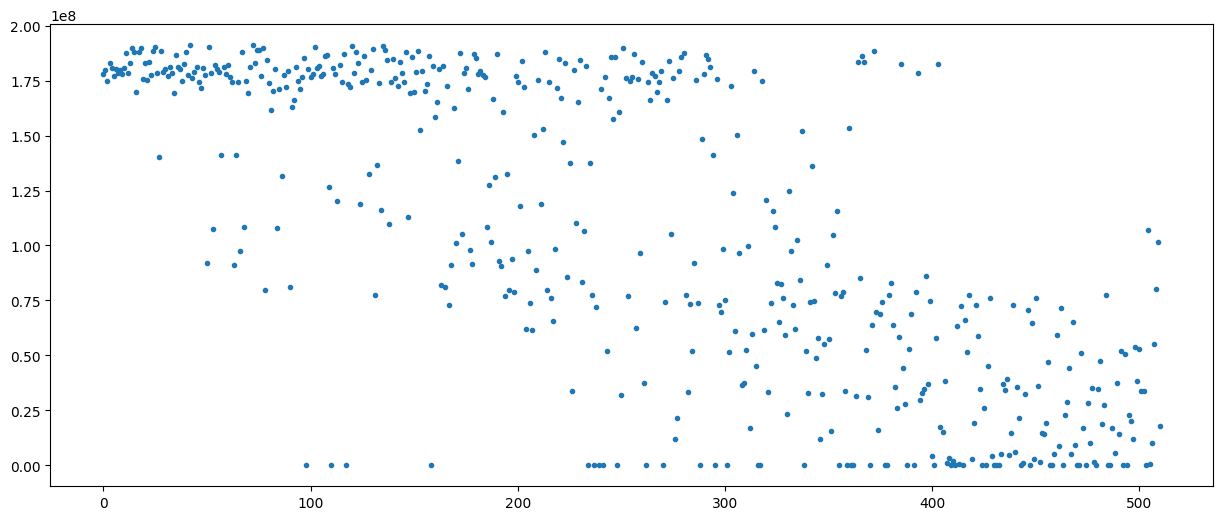

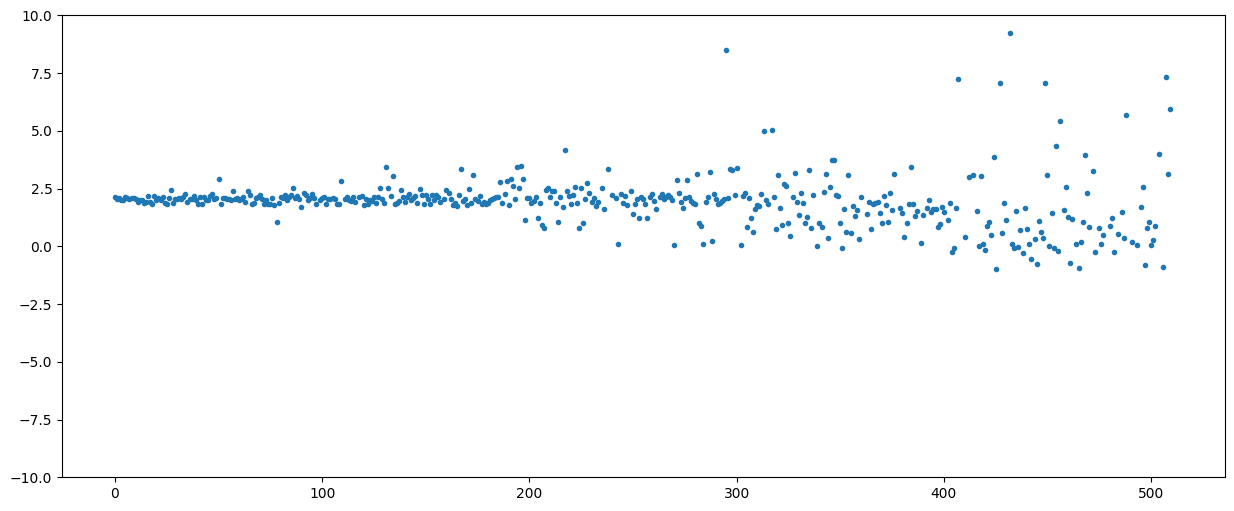

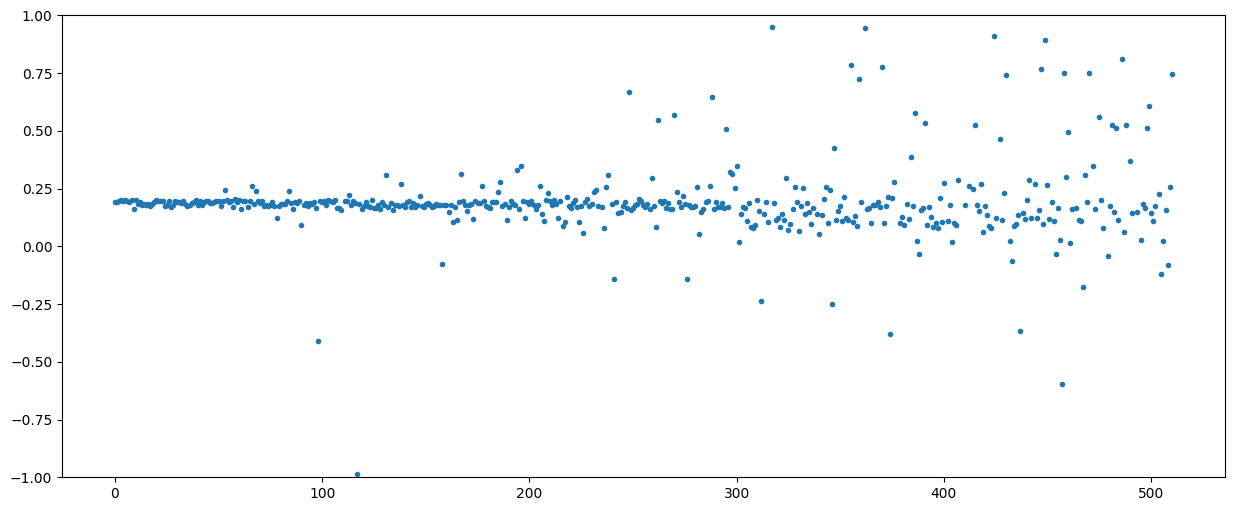

In [99]:
# 検証データの確認
for i in range(data_dim, data_dim+6):
    
    # iが2の場合のみ、ylimを設定
    if i == data_dim + 2:
        plt.ylim(0, 20)
        plt.plot(np.log10(-score_res_array[:, i]), ".")
    elif i == data_dim + 4:
        plt.ylim(-10, 10)
        plt.plot(score_res_array[:, i], ".")
    elif i == data_dim + 5:
        plt.ylim(-1, 1)
        plt.plot(score_res_array[:, i], ".")
    else:
        plt.plot(score_res_array[:, i], ".")
    
    plt.show()

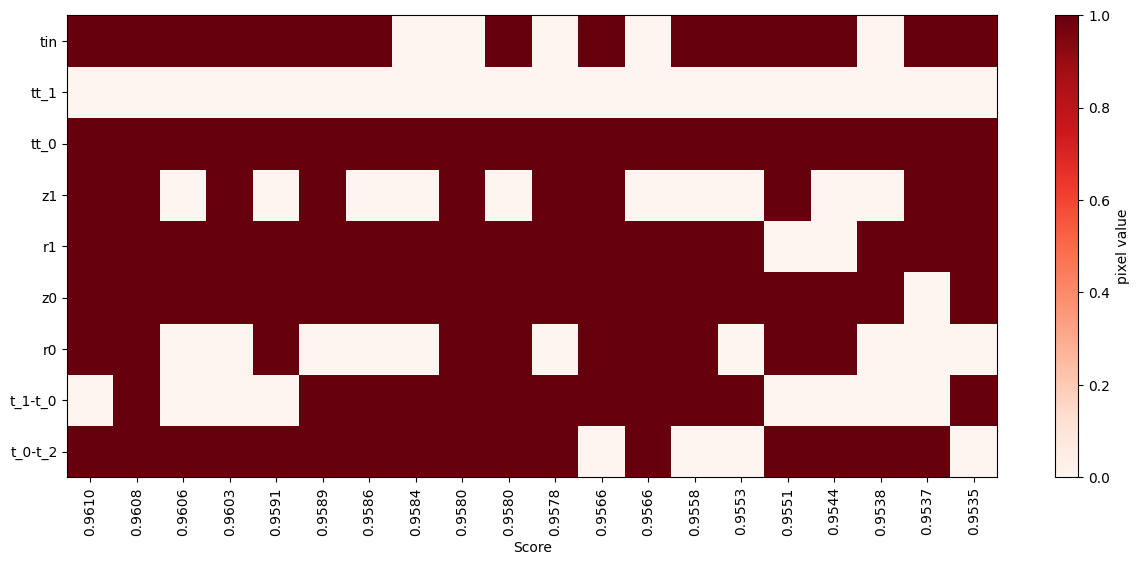

In [116]:
# score value 6列目で降順に並べ替え
sorted_array = score_res_array[score_res_array[:, data_dim].argsort()[::-1]]

#score max_lank10 array
max_lank10=10
rank10_array_score = sorted_array[0:max_lank10, 0:data_dim].T

plt.rcParams['figure.figsize'] = 15,6
plt.rcParams["font.size"] = 10

max_lank = 20
# pcolorでピクセルプロットを作成 for lanking top max_lank
plt.pcolor(sorted_array[0:max_lank, 0:data_dim].T, cmap="Reds")

# x軸の目盛りを設定
x_labels = ["{:.4f}".format(x) for x in sorted_array[0:max_lank, data_dim]]
plt.xticks(np.arange(0.5, max_lank+0.5), x_labels, rotation='vertical')

# y軸のラベルを設定
plt.yticks(np.arange(0.5, len(column_name) + 0.5), column_name)

plt.xlabel("Score")
#plt.ylabel("Explanatory Variables")
plt.colorbar(label="pixel value")
plt.savefig(f'plt/heatmap_1000keV-4_score.png')
plt.show()

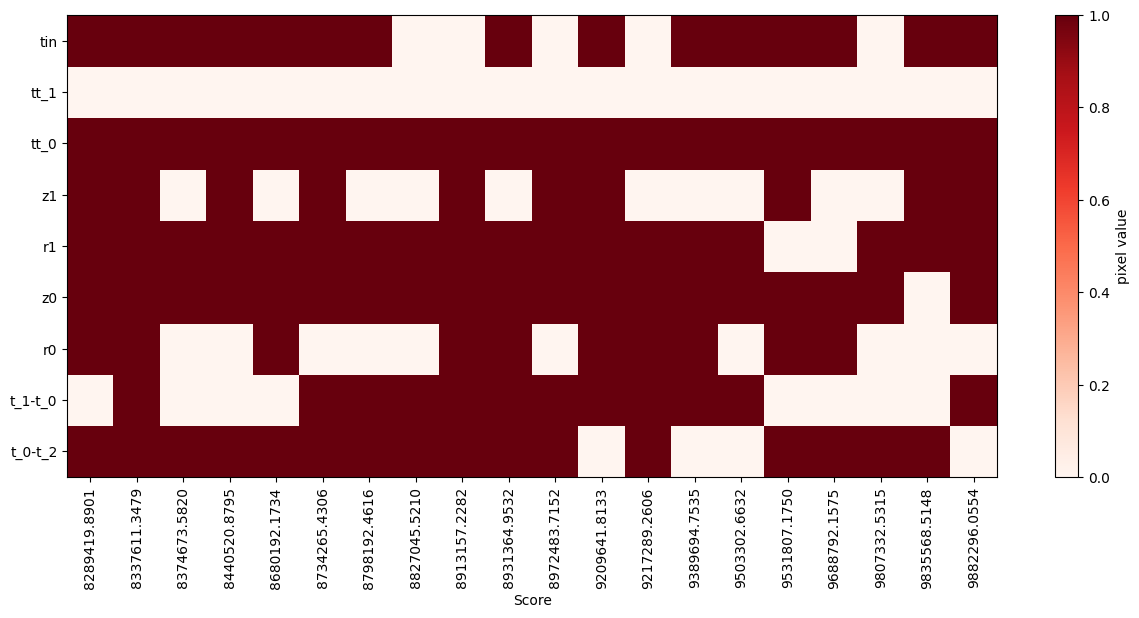

In [134]:
# MSE value で降順に並べ替え
sorted_array = score_res_array[score_res_array[:, data_dim+1].argsort()[::1]]

plt.rcParams['figure.figsize'] = 15,6
plt.rcParams["font.size"] = 10

max_lank = 20
# pcolorでピクセルプロットを作成 for lanking top max_lank
plt.pcolor(sorted_array[0:max_lank, 0:data_dim].T, cmap="Reds")

# x軸の目盛りを設定
x_labels = ["{:.4f}".format(x) for x in sorted_array[0:max_lank, data_dim+1]]
plt.xticks(np.arange(0.5, max_lank+0.5), x_labels, rotation='vertical')

# y軸のラベルを設定
plt.yticks(np.arange(0.5, len(column_name) + 0.5), column_name)

plt.xlabel("Score")
#plt.ylabel("Explanatory Variables")
plt.colorbar(label="pixel value")
plt.savefig(f'plt/heatmap_1000keV-4_mse.png')
plt.show()

In [135]:
print(sorted_array[0:20, data_dim])

[0.96097901 0.96075216 0.9605777  0.96026773 0.95913952 0.95888498
 0.95858405 0.95844823 0.95804288 0.95795717 0.95776361 0.95664723
 0.95661123 0.95579966 0.95526487 0.95513069 0.95439171 0.9538337
 0.95370079 0.95348083]


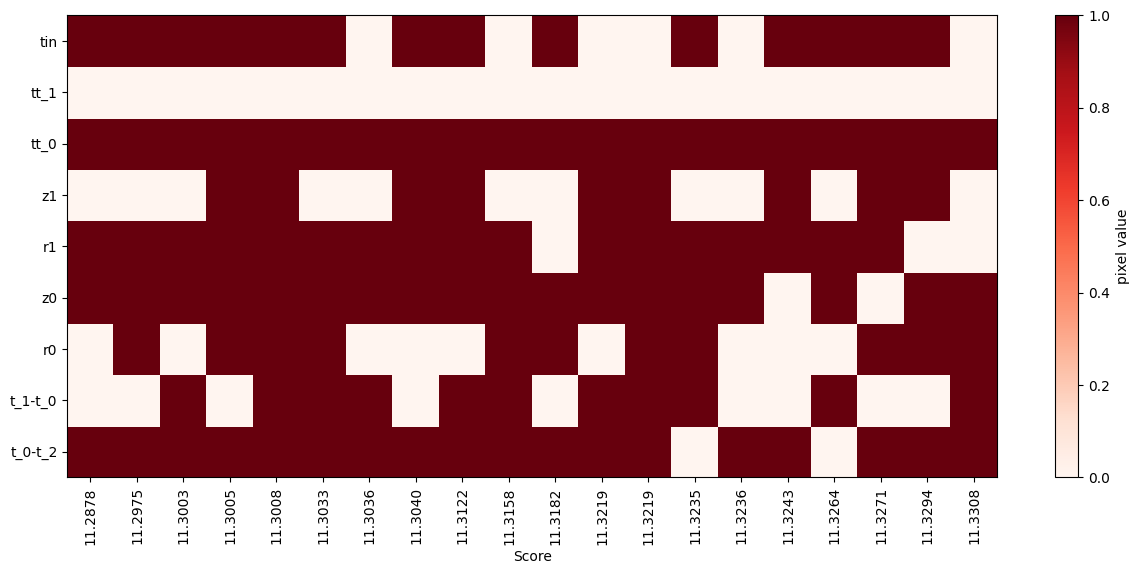

In [136]:
# LML value 列目で降順に並べ替え
sorted_array = score_res_array[np.log10(-score_res_array[:, data_dim+2]).argsort()[::1]]

#score max_lank10 array
max_lank10=10
rank10_array_LML = sorted_array[0:max_lank10, 0:data_dim].T

plt.rcParams['figure.figsize'] = 15,6
plt.rcParams["font.size"] = 10

max_lank = 20
# pcolorでピクセルプロットを作成 for lanking top max_lank
plt.pcolor(sorted_array[0:max_lank, 0:data_dim].T, cmap="Reds")

# x軸の目盛りを設定
x_labels = ["{:.4f}".format(x) for x in np.log10(-sorted_array[0:max_lank, data_dim+2])]
plt.xticks(np.arange(0.5, max_lank+0.5), x_labels, rotation='vertical')

# y軸のラベルを設定
plt.yticks(np.arange(0.5, len(column_name) + 0.5), column_name)

plt.xlabel("Score")
#plt.ylabel("Explanatory Variables")
plt.colorbar(label="pixel value")
plt.savefig(f'plt/heatmap_1000keV-4_LML.png')
plt.show()

In [103]:
# score_res_arrayをテキストファイルに保存
np.savetxt("score_res_array_1000keV-4-LML.txt", score_res_array, delimiter=" ", fmt="%s")

In [137]:
print(np.log10(-sorted_array[0:20, data_dim+2]))

[11.28775289 11.2974757  11.30030747 11.3004507  11.30076393 11.30332325
 11.30359538 11.30402421 11.31218095 11.31579357 11.31817936 11.32185197
 11.32187206 11.32350857 11.32355556 11.32432799 11.32643754 11.32706638
 11.32937723 11.33080786]


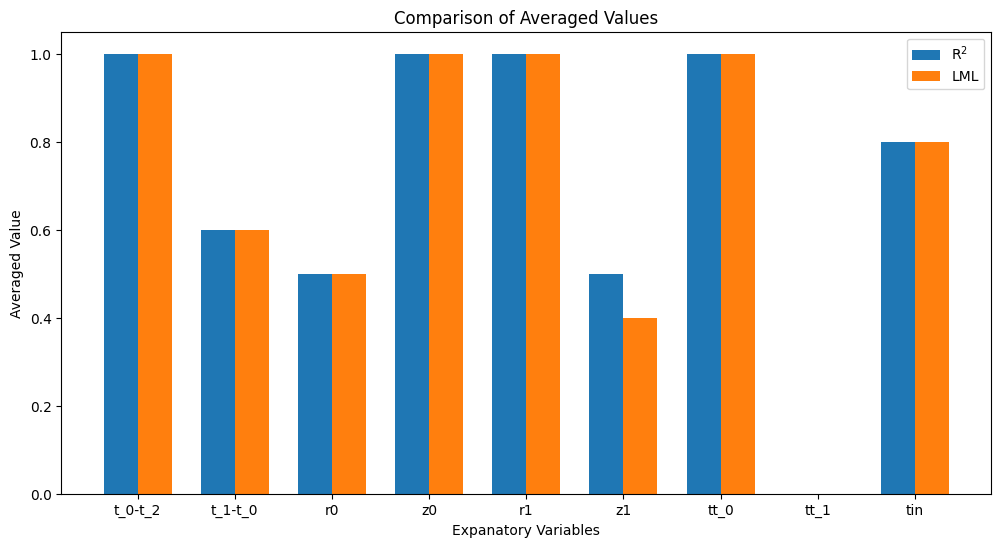

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the averages of each row for both arrays
averages_rank10_array_score = rank10_array_score.mean(axis=1)
averages_rank10_array_LML = rank10_array_LML.mean(axis=1)

# Row names
row_names = ['t_0-t_2', 't_1-t_0', 'r0', 'z0', 'r1', 'z1', 'tt_0', 'tt_1', 'tin']
#row_names = ['$\Delta$ $_{tor}$', 't_1-t_0', 'r0', 'z0', 'r1', 'z1', 'tt_0', 'tt_1', 'tin']

# Create the bar graph
fig, ax = plt.subplots(figsize=(12, 6))
#plt.rcParams["font.size"] = 10

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
index = np.arange(len(row_names))

# Plot the bars
bar1 = ax.bar(index, averages_rank10_array_score, bar_width, label='R$^{2}$')
bar2 = ax.bar(index + bar_width, averages_rank10_array_LML, bar_width, label='LML')

# Add labels, title, and legend
ax.set_xlabel('Expanatory Variables')
ax.set_ylabel('Averaged Value')
ax.set_title('Comparison of Averaged Values')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(row_names)
ax.legend()

# Display the bar graph
plt.savefig(f'bargraph_1000keV_R2LML.png')
plt.show()
